In [1]:
import os.path

import  torch
from ultralytics import YOLO
import sys

import pandas as pd
import numpy as np
from PIL import Image
import os

In [2]:
print(torch.version.cuda)
print(torch.__version__)
print(sys.version)

11.8
2.3.0
3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]


In [3]:
#Verificar si CUDA esta disponible
if torch.cuda.is_available():
    print('CUDA is available')
    print('Numero de GPUs disponible: ', torch.cuda.device_count())
    print('Nombre de la GPU: ', torch.cuda.get_device_name(0))
else:
    print('CUDA is not available')
    

CUDA is available
Numero de GPUs disponible:  1
Nombre de la GPU:  NVIDIA GeForce RTX 3060 Laptop GPU


# Parse de una Cedula de Identidad mediante Yolo V8 y DocTR
El presente Jupyter Notebook tiene como objetivo delinear la metodología empleada para el parseo de una cédula de identidad ecuatoriana hacia datos estructurados mediante el uso de una Red Neuronal Convolucional (CNN) desarrollada bajo el algoritmo YOLOv8.

Para el proceso de Reconocimiento Óptico de Caracteres (OCR), se utiliza la biblioteca DocTR, seleccionada por su superior rendimiento en comparación con otras bibliotecas OCR como Tesseract. Esta elección se fundamenta en la integración de DocTR con diversas técnicas de aprendizaje profundo (deep learning) durante el proceso de entrenaminto de sus modelos de deteccion ed caracteres, lo cual permite una estimación más precisa del texto presente en las imágenes.

In [4]:
# Se carga los modelos previamente entrenado mediante el algortimo de YOLO
model_recognize_CI = YOLO('runs/detect/train/weights/best.pt')
model_recognize_fields = YOLO('runs/detect/train4/weights/best.pt')

## Extraccion de las regiones de Interes donde se encuentre una cedula de identidad
Como primer paso se ejecuta el modelo model_recognize_DNI, el cual tiene como finalidad identificar si dentro del archivo enviado existe un cedula de identidad(Ya sea la parte frontal o e reverso) En caso de detectarse una cedula de identidad se extrae la imagen presente dentro del Boung Box

In [13]:
# Como primer paso se ejecuta el modelo model_recognize_DNI, el cual tiene como finalidad identificar si dentro del archivo enviado existe un cedula de identidad(Ya sea la parte frontal o e reverso) En caso de detectarse una cedula de identidad se extrae la imagen presente dentro del Boung Box

path_image = r"C:\Users\crisb\Downloads\m755_foto_cedula.jpg"
region_ci = model_recognize_CI(path_image)

# Process results list
for result in region_ci:
    region_ci_boxes = result.boxes  # Boxes object for bounding box outputs
    region_ci_masks = result.masks  # Masks object for segmentation masks outputs
    region_ci_keypoints = result.keypoints  # Keypoints object for pose outputs
    region_ci_probs = result.probs  # Probs object for classification outputs
    region_ci_obb = result.obb  # Oriented boxes object for OBB outputs
    #result.show()  # display to screen
    path_save = os.path.join('Pruebas_random/Results', 'result_CI_identify.jpg')
    result.save(filename=path_save)  # save to disk
    


image 1/1 C:\Users\crisb\Downloads\m755_foto_cedula.jpg: 640x480 1 CI_Frontal, 1 CI_Reverso, 112.0ms
Speed: 1415.7ms preprocess, 112.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


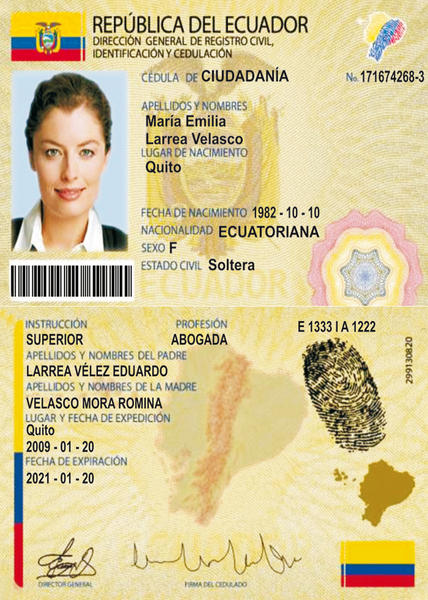

In [14]:
# Se grafica la imagen original que a la cual se le realizara todo el procedimiento
# Cargar la imagen
image_original = Image.open(path_image)
width, height = image_original.size
display(image_original)

In [15]:
# Creamos un Datframe en el cual vamos a almacenar toda la informacion sobre la extraccion de las regiones en la cual se encuentran as cedulas de identidad
# Incluyendo la confianza de la prediccion, la clase, las coordenadas xyxyn y xywhn
df_regions_ci = pd.DataFrame(columns=['confidence', 'clase', 'coordenate xyxyn', 'coordenate xywhn'])
coordante_xyxyn = []
coordante_xywhn = []
for index, confidence in enumerate(region_ci_boxes.conf):
    if confidence.cpu().item() > 0.80:
        new_register = {
            'confidence': region_ci_boxes.conf[index].cpu().item(),
            'clase': region_ci_boxes.cls[index].cpu().item(), 
            'coordenate xyxyn': region_ci_boxes.xyxy[index].cpu().numpy(),
            'coordenate xywhn': region_ci_boxes.xywhn[index].cpu().numpy()
        }
        df_regions_ci.loc[len(df_regions_ci)] = new_register

In [16]:
df_regions_ci

,confidence,clase,coordenate xyxyn,coordenate xywhn
0,0.954759,1.0,"[1.4631842, 305.37573, 427.06427, 599.47455]","[0.5006162, 0.7540419, 0.994395, 0.4901647]"
1,0.944800,0.0,"[0.6763744, 0.31482694, 428.0, 305.96155]","[0.5007901, 0.2552303, 0.9984197, 0.5094112]"


In [17]:
# Se procede a recortarse las regiones en las cuales se detecto que existe una cedula de identidad
cropped_images = []
for index, row in df_regions_ci.iterrows():
    crop_area = tuple(row['coordenate xyxyn'])
    cropped_image = image_original.crop(crop_area)
    cropped_images.append(cropped_image)


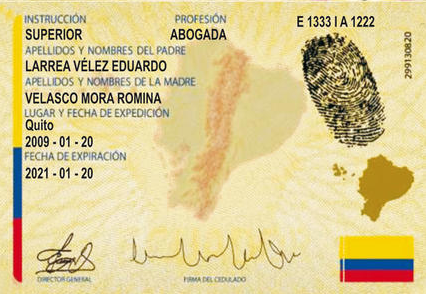

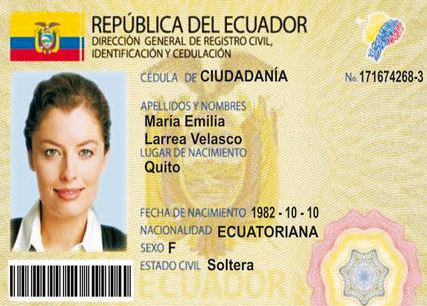

In [18]:
# Se indican las regiones de interes donde se encuentra la cedula de identidad. En este caso no es necesario tener una precision alta en los Bounding Boxex sino es mas importante que el documento dentro de dicha zona de interes corresponde a una cedula de identidad. Esto con la finalidad de posteriormente escalar el sistema a otros tipos de documentos
for img in cropped_images:
    # Convertir la imagen de NumPy a objeto PIL Image
    # Mostrar la imagen en el cuaderno
    display(img)

## Extraccion de los campos de la cedula de identidad
Una vez contamos con las regiones de interes donde se encuentra la cedula de identidad, se procede a utilizar el modelo de deteccion de regiones de Interes de los campos de la cedula de identidad. Para ello se ejecuta el modelo model_recognize_fields, el cual tiene como finalidad identificar los campos presentes en la cedula de identidad y extraer la informacion presente en cada uno de ellos.

In [19]:
region_fields_images = []
count = 0
for img in cropped_images:
    count += 1
    fields_CI = model_recognize_fields(img)
    region_fields_images.append(fields_CI)
    for result in fields_CI:
        fields_CI_boxes = result.boxes  # Boxes object for bounding box outputs
        fields_CI_masks = result.masks  # Masks object for segmentation masks outputs
        fields_CI_keypoints = result.keypoints  # Keypoints object for pose outputs
        fields_CI_probs = result.probs  # Probs object for classification outputs
        fields_CI_obb = result.obb  # Oriented boxes object for OBB outputs
        #result.show()  # display to screen
        path_save = os.path.join('Pruebas_random/Results', 'result_Fields' + str(count) + '.jpg')
        result.save(filename=path_save)  # save to disk


0: 448x640 1 Instruccion, 1 Profesion, 1 Nombres Padre, 1 Nombres Madre, 1 Lugar Expedicion, 1 Fecha Expedicion, 1 Fecha Expiracion, 1 Codigo Dactilar, 1 Huella, 200.0ms
Speed: 0.0ms preprocess, 200.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 Foto, 1 ID, 1 Apellidos, 1 Nombres, 1 Fecha Nacimiento, 1 Nacionalidad, 1 Sexo, 1 Estado Civil, 126.7ms
Speed: 0.0ms preprocess, 126.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


In [20]:
# Creamos un Datframe en el cual vamos a almacenar toda la informacion sobre la extraccion de las regiones en la cual se encuentran as cedulas de identidad
# Incluyendo la confianza de la prediccion, la clase, las coordenadas xyxyn y xywhn
df_fields_ci = pd.DataFrame(columns=['confidence', 'clase', 'coordenate xyxyn', 'coordenate xywhn', 'name_class'])
coordante_xyxyn = []
coordante_xywhn = []
clases_names = region_fields_images[0][0].names

for img_predict_fields in region_fields_images:
    for index, confidence in enumerate(img_predict_fields[0].boxes.conf):
        if confidence.cpu().item() > 0.50:
            new_register = {
                'confidence': img_predict_fields[0].boxes.conf[index].cpu().item(),
                'clase': img_predict_fields[0].boxes.cls[index].cpu().item(), 
                'coordenate xyxyn': img_predict_fields[0].boxes.xyxy[index].cpu().numpy(),
                'coordenate xywhn': img_predict_fields[0].boxes.xywhn[index].cpu().numpy(),
                'name_class': clases_names[int(img_predict_fields[0].boxes.cls[index].cpu().item())]
            }
            df_fields_ci.loc[len(df_fields_ci)] = new_register

In [21]:
df_fields_ci

,confidence,clase,coordenate xyxyn,coordenate xywhn,name_class
0,0.967366,11.0,"[169.58128, 27.08837, 226.81435, 41.595276]","[0.46525308, 0.11680892, 0.13434991, 0.049343217]",Profesion
1,0.957864,18.0,"[302.2435, 33.792717, 387.86728, 148.77075]","[0.8099892, 0.31048208, 0.20099479, 0.39108175]",Huella
2,0.938650,10.0,"[25.532372, 27.830463, 83.81983, 41.269657]","[0.12834767, 0.11751721, 0.13682503, 0.045711543]",Instruccion
3,0.926357,12.0,"[24.533028, 57.989944, 166.08443, 73.03295]","[0.22372942, 0.22282803, 0.33228028, 0.05116669]",Nombres Padre
4,0.901855,13.0,"[24.763329, 90.91227, 162.73103, 105.19558]","[0.2200638, 0.33351675, 0.3238679, 0.048582684]",Nombres Madre
5,0.845281,16.0,"[24.681091, 166.45518, 93.78783, 180.2484]","[0.13904803, 0.5896319, 0.16222239, 0.046915688]",Fecha Expiracion
6,0.825274,17.0,"[296.43994, 15.052945, 375.64413, 28.465248]","[0.7888311, 0.07401053, 0.18592533, 0.045620076]",Codigo Dactilar
7,0.986140,0.0,"[10.995899, 71.11698, 126.799355, 250.66916]","[0.16135275, 0.5257943, 0.27120245, 0.58677185]",Foto
8,0.963145,7.0,"[217.67155, 223.88708, 319.40298, 238.58235]","[0.62889284, 0.755669, 0.2382469, 0.04802375]",Nacionalidad
9,0.915119,4.0,"[145.93398, 132.83064, 242.90855, 144.83786]","[0.4553191, 0.45370674, 0.22710674, 0.039239272]",Nombres


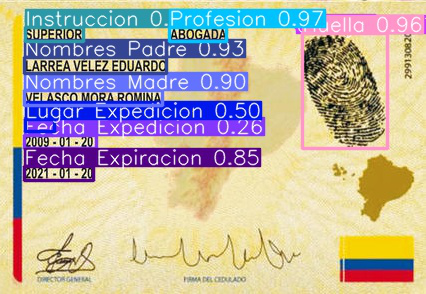

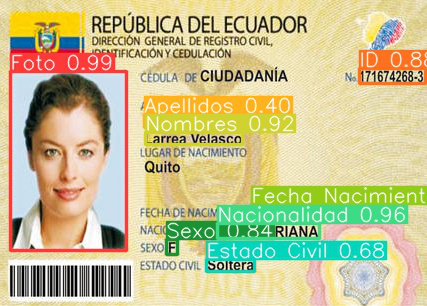

In [23]:
img_fields_1 = Image.open('Pruebas_random/Results/result_Fields1.jpg')
img_fields_2 = Image.open('Pruebas_random/Results/result_Fields2.jpg')
display(img_fields_1)
display(img_fields_2)